In [1]:
# different by splitting to train test valid (here valid and test are switched)

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import time
import warnings
import torch.nn as nn
import pickle
from dataset_loader import *
from utils import *
import pandas as pd
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
from retrain_utils import *

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
dataset_name = 'corona'
ds = get_ds(dataset_name)

In [5]:
test_valid = ds['test'].train_test_split(0.5)
ds = DatasetDict({
    'train': ds['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [6]:
model_name = 'huawei-noah/TinyBERT_General_4L_312D'
folder_name = 'gru'

In [12]:
retrain_utils = RetrainUtils(model_name, dataset_name)
added_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.ADD)
removed_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.REMOVE)
replaced_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.REPLACE)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /home/almr16/.cache/huggingface/hub/models--huawei-noah--TinyBERT_General_4L_312D/snapshots/34707a33cd59a94ecde241ac209bf35103691b43/config.json
Model config BertConfig {
  "_name_or_path": "huawei-noah/TinyBERT_General_4L_312D",
  "attention_probs_dropout_prob": 0.1,
  "cell": {},
  "classifier_dropout": null,
  "emb_size": 312,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 1200,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "pre_trained": "",
  "structure": [],
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /ho

In [13]:
ds['train'] = removed_train

In [14]:
# 50 padding for sentiment, 64 for corona
set_seed()    
model = MyGRU(model_name, hidden_dim=256, num_layers=2, output_dim=2, dropout=0.0)
tokenized_data = tokenize_dataset(ds, tokenizer_name=model_name, max_length = 64)
train(model, tokenized_data, path=f'{folder_name}/{dataset_name}/check', num_train_epochs=20)

loading configuration file config.json from cache at /home/almr16/.cache/huggingface/hub/models--huawei-noah--TinyBERT_General_4L_312D/snapshots/34707a33cd59a94ecde241ac209bf35103691b43/config.json
Model config BertConfig {
  "_name_or_path": "huawei-noah/TinyBERT_General_4L_312D",
  "attention_probs_dropout_prob": 0.1,
  "cell": {},
  "classifier_dropout": null,
  "emb_size": 312,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 1200,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "pre_trained": "",
  "structure": [],
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /home/almr16/.cache/huggingface/hub/models--huawei-noah--TinyBERT_General_4L_312

  0%|          | 0/6497 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

PyTorch: setting up devices
The following columns in the training set don't have a corresponding argument in `MyGRU.forward` and have been ignored: token_type_ids, attention_mask. If token_type_ids, attention_mask are not expected by `MyGRU.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 6497
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4080


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.692960,0.521000
2,No log,0.693223,0.520000
3,0.693200,0.692708,0.522000
4,0.693200,0.692496,0.522000
5,0.691800,0.694090,0.487000
6,0.691800,0.689613,0.529000
7,0.691800,0.571067,0.713000
8,0.629500,0.508752,0.751000
9,0.629500,0.504587,0.779000
10,0.338900,0.493937,0.790000


The following columns in the evaluation set don't have a corresponding argument in `MyGRU.forward` and have been ignored: token_type_ids, attention_mask. If token_type_ids, attention_mask are not expected by `MyGRU.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32
Saving model checkpoint to gru/corona/check/checkpoint-204
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
The following columns in the evaluation set don't have a corresponding argument in `MyGRU.forward` and have been ignored: token_type_ids, attention_mask. If token_type_ids, attention_mask are not expected by `MyGRU.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32
Saving model checkpoint to gru/corona/check/checkpoint-408
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
The following columns in the evaluation set don't have a corresponding argum

TrainOutput(global_step=4080, training_loss=0.3552736535960553, metrics={'train_runtime': 70.1935, 'train_samples_per_second': 1851.168, 'train_steps_per_second': 58.125, 'total_flos': 0.0, 'train_loss': 0.3552736535960553, 'epoch': 20.0})

In [16]:
torch.save(model.state_dict(), f'{folder_name}/{dataset_name}/updated_model2/pytorch_model.bin')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

### saved best model's folder as 'updated_model'

In [ ]:
model = load_gru(f'{folder_name}/{dataset_name}/updated_model2').to(device)
model = model.eval()

In [ ]:
orig_model = load_gru(f'{folder_name}/{dataset_name}/model').to(device)
orig_model = orig_model.eval()

In [ ]:
tokenized_data = tokenize_dataset(ds, tokenizer_name=model_name, max_length = 64)

In [22]:
train(model, tokenized_data, path=f'{folder_name}/{dataset_name}', evaluate = True)

PyTorch: setting up devices
The following columns in the evaluation set don't have a corresponding argument in `MyGRU.forward` and have been ignored: token_type_ids, attention_mask. If token_type_ids, attention_mask are not expected by `MyGRU.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32


{'eval_loss': 0.683180570602417,
 'eval_accuracy': 0.816,
 'eval_runtime': 0.2492,
 'eval_samples_per_second': 4013.074,
 'eval_steps_per_second': 128.418}

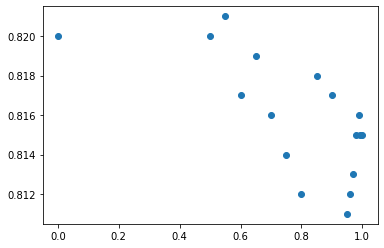

In [23]:
ths = [0.0, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.96, 0.97, 0.98, 0.99, 0.993, 1]
accs = []
for th in ths:
    ensemble = Ensemble(model, orig_model, th)
    acc = calc_accuracy(ensemble, ds['test'], tokenizer)[0]
    accs.append(acc)
_ = plt.scatter(ths, accs)

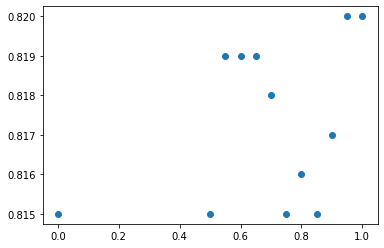

In [24]:
ths = [0.0, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1]
accs = []
for th in ths:
    ensemble = Ensemble(orig_model, model, th)
    acc = calc_accuracy(ensemble, ds['test'], tokenizer)[0]
    accs.append(acc)
_ = plt.scatter(ths, accs)

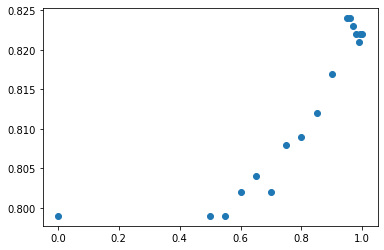

In [25]:
ths = [0.0, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.96, 0.97, 0.98, 0.99, 0.993, 1]
accs = []
for th in ths:
    ensemble = Ensemble(model, orig_model, th)
    acc = calc_accuracy(ensemble, ds['valid'], tokenizer)[0]
    accs.append(acc)
_ = plt.scatter(ths, accs)

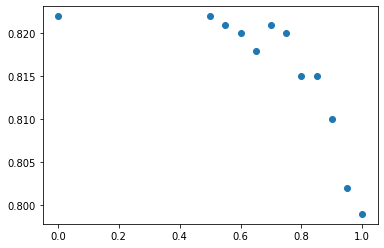

In [26]:
ths = [0.0, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1]
accs = []
for th in ths:
    ensemble = Ensemble(orig_model, model, th)
    acc = calc_accuracy(ensemble, ds['valid'], tokenizer)[0]
    accs.append(acc)
_ = plt.scatter(ths, accs)

In [ ]:
def predict_sentences(sentences, m):
    encoded = [[101] +[tokenizer._convert_token_to_id_with_added_voc(token) for token in tokens] + [102]         
               for tokens in sentences]
    to_pred = torch.tensor(encoded, device=device)
    outputs = m(to_pred)[0]
    print(outputs)
    return torch.argmax(outputs, dim=1).cpu().numpy()

In [13]:
predict_sentences([tokenizer.tokenize("i hate movies")])

tensor([[ 1.7911, -1.7094]], device='cuda:0', grad_fn=<AddmmBackward0>)


array([0])

In [14]:
predict_sentences([tokenizer.tokenize("i love movies")])

tensor([[-2.3436,  2.2181]], device='cuda:0', grad_fn=<AddmmBackward0>)


array([1])